In [71]:
from myhdl import * 
from myhdlpeek.myhdl import Peeker
from random import randrange

Adding the instructions from the 'Instructions' file to the Instruction Memory

In [72]:
binary_file = open("instructions2", "rb")
instMemory = [intbv(0)[32:0] for _ in range(9)]
#instMemory[0][:] = int('00000000000000000000000000000000', 2) #since the pc starts at 1 in testing part
c = 0

for line in binary_file:
    newLine = line.decode("utf-8")
    instMemory[c][:] = int(newLine, 2)
    c+=1 

#print(bin(instMemory[0][32:26])) #if the 1st 6 bits are '0' then a single Zero is the output
#print(bin(instMemory[5][32:26])) #otherwise, all 6 bits are present [if we remove 'bin' result is in hexadecimal]

binary_file.close()    


Program Counter Adder Unit

In [73]:
def pc_adder(curr_pc, outPcAdder):
    @always_comb
    def pc_add():
        outPcAdder.next = curr_pc + 1
    return pc_add    


Branch Adder Unit

In [74]:
def branch_adder(outPcAdder, addr, out):
    @always_comb
    def branch_add():
        out.next = outPcAdder + addr  
    return branch_add    

Program Counter Unit

In [75]:
def program_counter(curr_pc, next_pc, clk):
    @always(clk.posedge)
    def pc():
        curr_pc.next = next_pc 

    return pc 


Instruction Memory Unit

In [76]:
def instruction_memory(curr_pc, curr_inst, clk):

    @always(clk.negedge)
    def imem():
        curr_inst.next = instMemory[curr_pc]

    return imem

The Decoder Unit

In [77]:
def decoder(curr_inst,Opcode,Rs,Rt,Rd,shamt,funct,addr):
    @always_comb
    def decoderBehave():
        Opcode.next=curr_inst[32:26]
        Rs.next=curr_inst[26:21]
        Rt.next=curr_inst[21:16]
        Rd.next=curr_inst[16:11]
        shamt.next=curr_inst[11:6]
        funct.next=curr_inst[6:]
        addr.next=curr_inst[16:]
    return decoderBehave

The Control Unit

In [78]:
def ControlUnit(Opcode,funct,RegDst,RegWrite,ALUSrc,ALUOp,MemWrite,MemRead,MemToReg,branch):
    @always_comb
    def ControlUnitbehavior():
        if Opcode==0:
            if funct==32:
                RegDst.next=1
                RegWrite.next=1
                ALUSrc.next=0
                MemWrite.next=0
                MemRead.next=0
                MemToReg.next=0
                branch.next=0
                ALUOp.next=2
            if funct==34:
                RegDst.next=1
                RegWrite.next=1
                ALUSrc.next=0
                MemWrite.next=0
                MemRead.next=0
                MemToReg.next=0
                branch.next=0
                ALUOp.next=6
            if funct==54:
                RegDst.next=1
                RegWrite.next=1
                ALUSrc.next=0
                MemWrite.next=0
                MemRead.next=0
                MemToReg.next=0
                branch.next=0
                ALUOp.next=0
            if funct==55:
                RegDst.next=1
                RegWrite.next=1
                ALUSrc.next=0
                MemWrite.next=0
                MemRead.next=0
                MemToReg.next=0
                branch.next=0
                ALUOp.next=1
            if funct==56:
                RegDst.next=1
                RegWrite.next=1
                ALUSrc.next=0
                MemWrite.next=0
                MemRead.next=0
                MemToReg.next=0
                branch.next=0
                ALUOp.next=3
        else:
            if Opcode==8 :
                RegDst.next=0
                RegWrite.next=1
                ALUSrc.next=1
                MemWrite.next=0
                MemRead.next=0
                MemToReg.next=0
                branch.next=0
                ALUOp.next=2
            if Opcode==36:
                RegDst.next=0
                RegWrite.next=1
                ALUSrc.next=1
                MemWrite.next=0
                MemRead.next=0
                MemToReg.next=0
                branch.next=0
                ALUOp.next=6
            if Opcode==35:
                RegDst.next=0
                RegWrite.next=1
                ALUSrc.next=1
                MemWrite.next=0
                MemRead.next=1
                MemToReg.next=1
                branch.next=0
                ALUOp.next=2
            if Opcode==43:
                RegWrite.next=0
                ALUSrc.next=1
                MemWrite.next=1
                MemRead.next=0
                branch.next=0
                ALUOp.next=2
            if Opcode == 4:
                RegWrite.next=0
                ALUSrc.next=0
                MemWrite.next=0
                MemRead.next=0
                branch.next=1
                ALUOp.next=6
    return ControlUnitbehavior

Building the Register File

In [79]:
regFile = [intbv(0)[32:0] for _ in range(32)]
""" i = 0
for i in range(10):
    regFile[i][:] = randrang(10)
    i += 1 """

regFile = [5,2,1,4,5,6,7,8,4,3,5,2,1,4,5,6,7,8,4,3,5,2,1,4,5,6,7,8,4,3,5,1]
print(regFile[13], regFile[22])

4 1


The Register File Unit

In [80]:
def register_file(regWrite, rs, rt, outMUX, memOrALU, data1, data2, clk):
    @always(clk.posedge)
    def writing():
        if(regWrite == 1):
            regFile[outMUX] = memOrALU

    @always_comb
    def reading():
        data1.next = regFile[rs]
        data2.next = regFile[rt]
        print(rs, rt)
        print(regFile[rs], regFile[rt])

    return writing, reading    

ALU Unit

In [81]:
import operator
def ALU(op1,op2,ALUOp,res,zero_flag):
    @always_comb
    def ALUbeh():
        if ALUOp==2:
            res.next=op1+op2
            if (op1+op2)==0:
                zero_flag.next=1
            if (op1+op2)!=0:
                zero_flag.next=0

        if ALUOp==6:
            res.next=op1-op2
            if (op1-op2)==0:
                zero_flag.next=1
            if (op1-op2)!=0:
                zero_flag.next=0

        if ALUOp==0:
            res.next=op1 and op2
            if (op1 and op2)==0:
                zero_flag.next=1
            if (op1 and op2) !=0:
                zero_flag.next=0

        if ALUOp==1:
            res.next=op1 or op2
            if (op1 or op2)==0:
                zero_flag.next=1
            if (op1 or op2)!=0:
                zero_flag.next=0
        if ALUOp==3:
            res.next=operator.xor(op1,op2)
            if (operator.xor(op1,op2))==0:
                zero_flag.next=1
            if (operator.xor(op1,op2))!=0:
                zero_flag.next=0

    return instances()

The 5-bit MUX Unit

In [82]:
def mux5bit(z, a, b, sel):

    @always_comb
    def mux_logic():
        if sel == 1:
            z.next = a  
        else:
            z.next = b  
           
    return mux_logic

The 32-bit MUX Unit

In [83]:
def mux(z, a, b, sel):

    @always_comb
    def mux_logic():
        if sel == 1:
            z.next = a 
        else:
            z.next = b  
           
    return mux_logic

The Sign Extension Unit

In [84]:
def sign_extension(input, output):
    @always_comb
    def signEx():      
        output.next = input 
            
    return signEx        

Data Memory Unit

In [85]:
datamemory=[intbv(0)[32:0] for _ in range(65000)]
def datamem(MemRead,MemWrite,address,WriteData,ReadData,clk):
    @always(clk.posedge)
    def datamemwrite():
        if MemWrite==1:
            datamemory[address]=WriteData
            print("write data is:", WriteData, " address:", address, " data in address:", datamemory[address])
    @always_comb
    def datamemread():
        if MemRead==1:
            ReadData.next=datamemory[address]
            print("read data is:" , readData)
    return datamemread,datamemwrite

Testing !!

00 00
5 5
0f 0a
6 5
0d 16
b 1
12 12
4 4
16 17
1 4
write data is: 4  address: 3b  data in address: 4
read data is: 00000000
read data is: 00000004
19 15
4 2
12 15
4 b15


<class 'myhdl.StopSimulation'>: No more events


Time,Clock,Current instruction,Opcode,addr,alu Op,alu Src,branch,current pc,data 1,data 2,data 3,funct,mem Or ALU,memRead,memToReg,memWrite,next pc,out BranchAdder,out SigEx,out pc adder,out to Write Register,rd,readData,regDst,regWrite,result of alu,rs,rt,shamt,zero flag
0,True,00000000,00,0000,0,False,False,0,5,5,5,00,5,False,False,False,1,00000001,00000000,1,00,00,00000000,False,False,5,00,00,00,0
1,False,01ea6820,00,6820,2,False,False,0,6,5,5,20,b,False,False,False,1,00006821,00006820,1,0d,0d,00000000,1,1,b,0f,0a,00,0
2,True,01ea6820,00,6820,2,False,False,1,6,5,5,20,b,False,False,False,2,00006822,00006820,2,0d,0d,00000000,1,1,b,0f,0a,00,0
3,False,01b6c822,00,c822,6,False,False,1,b,1,1,22,a,False,False,False,2,0000c824,0000c822,2,19,19,00000000,1,1,a,0d,16,00,0
4,True,01b6c822,00,c822,6,False,False,2,b,1,1,22,a,False,False,False,3,0000c825,0000c822,3,19,19,00000000,1,1,a,0d,16,00,0
5,False,12520002,04,0002,6,False,1,2,4,4,4,02,0,False,False,False,5,00000005,00000002,3,00,00,00000000,1,0,0,12,12,00,1
6,True,12520002,04,0002,6,False,1,5,4,4,4,02,0,False,False,False,8,00000008,00000002,6,00,00,00000000,1,0,0,12,12,00,1
7,False,aed7003a,2b,003a,2,1,0,5,1,4,3a,3a,3b,False,False,1,6,00000040,0000003a,6,00,00,00000000,1,0,3b,16,17,00,0
8,True,aed7003a,2b,003a,2,1,0,6,1,4,3a,3a,3b,False,False,1,7,00000041,0000003a,7,00,00,00000000,1,0,3b,16,17,00,0
9,False,8ed7003a,23,003a,2,1,0,6,1,4,3a,3a,4,1,1,0,7,00000041,0000003a,7,17,00,00000004,0,1,3b,16,17,00,0


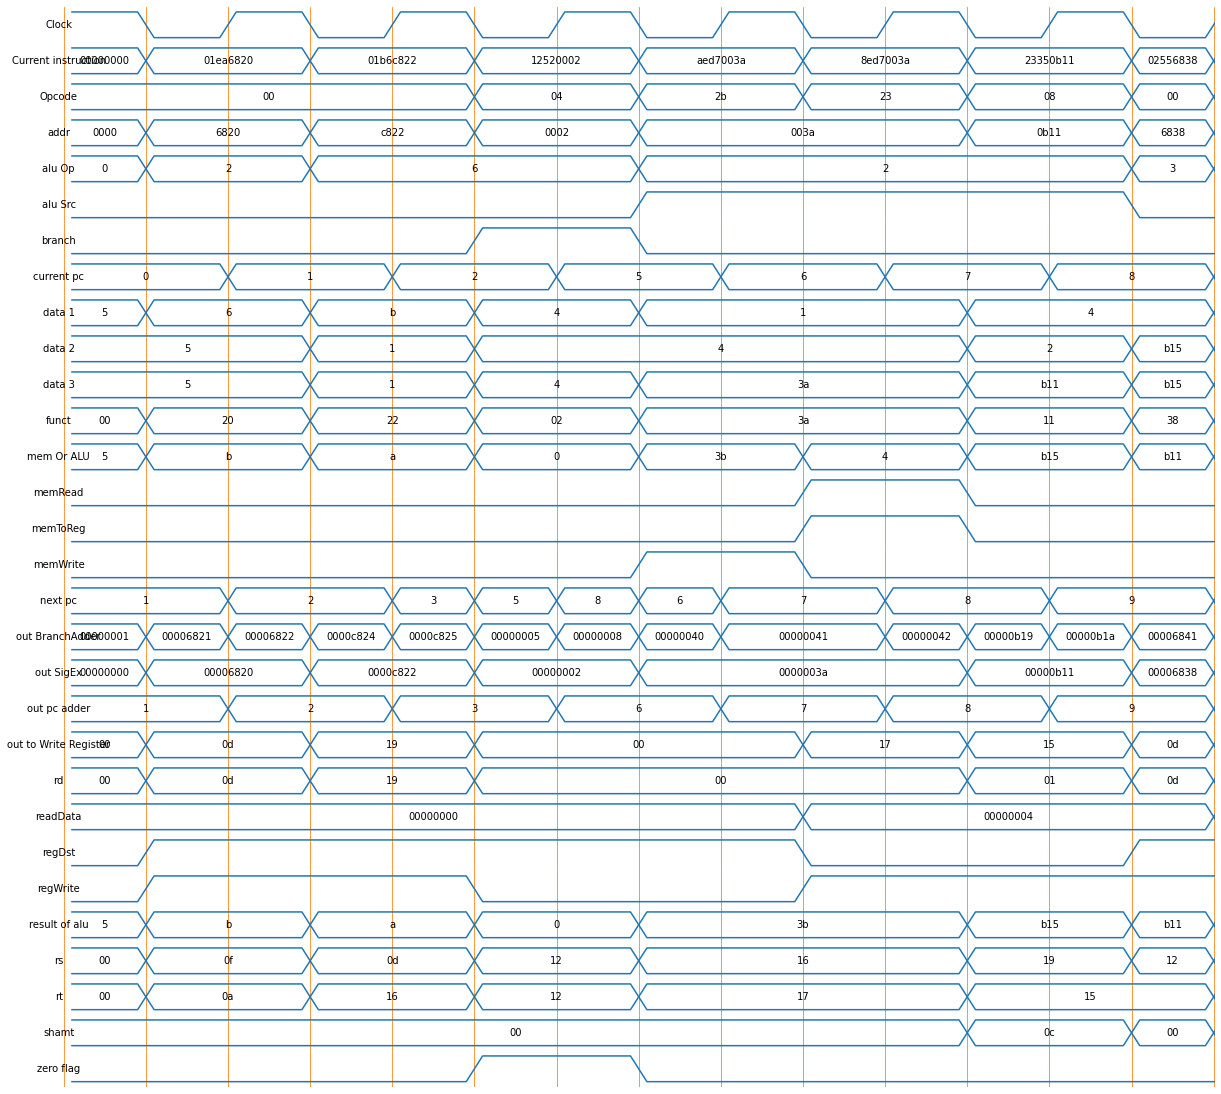

In [86]:
clk = Signal(bool(0))
curr_pc = Signal(intbv(-1))
next_pc = Signal(intbv(0))
outPcAdder = Signal(intbv(0))
curr_inst = Signal(intbv(0)[32:])
opcode = Signal(intbv(0)[6:])
rs = Signal(intbv(0)[5:])
rt = Signal(intbv(0)[5:])
rd = Signal(intbv(0)[5:])
outMux = Signal(intbv(0)[5:])
shamt = Signal(intbv(0)[5:])
funct = Signal(intbv(0)[6:])
addr = Signal(intbv(0)[16:])
regDst = Signal(bool(0))
regWrite = Signal(bool(0))
ALUSrc = Signal(bool(0))
ALUOp = Signal(intbv(0)[3:])
memWrite = Signal(bool(0))
memRead = Signal(bool(0))
memToReg = Signal(bool(0))
branch = Signal(bool(0))
memOrALU = Signal(intbv(0))
data1 = Signal(intbv(0))
data2 = Signal(intbv(0))
data3 = Signal(intbv(0))
outSigEx = Signal(intbv(0)[32:])
outBranchAdder = Signal(intbv(0)[32:]) #out from branch adder
aluRes = Signal(intbv(0))
zero_flag = Signal(bool(0))
readData=Signal(intbv(0)[32:])

Peeker(curr_pc, 'current pc')
Peeker(curr_inst, 'Current instruction')
Peeker(next_pc, 'next pc')
Peeker(outPcAdder, 'out pc adder')
Peeker(clk, 'Clock')
Peeker(opcode, 'Opcode')
Peeker(funct, 'funct')
Peeker(regDst, 'regDst')
Peeker(regWrite, 'regWrite')
Peeker(ALUSrc, 'alu Src')
Peeker(ALUOp, 'alu Op')
Peeker(memWrite, 'memWrite')
Peeker(memRead, 'memRead')
Peeker(memOrALU, 'mem Or ALU')
Peeker(memToReg, 'memToReg')
Peeker(branch, 'branch')
Peeker(outMux, 'out to Write Register')
Peeker(rs, 'rs')
Peeker(rt, 'rt')
Peeker(rd, 'rd')
Peeker(shamt, 'shamt')
Peeker(addr, 'addr')
Peeker(data1, 'data 1')
Peeker(data2, 'data 2')
Peeker(data3, 'data 3')
Peeker(outSigEx, 'out SigEx')
Peeker(outBranchAdder, 'out BranchAdder')
Peeker(aluRes, 'result of alu')
Peeker(zero_flag, 'zero flag')
Peeker(readData,'readData')


pcOne = program_counter(curr_pc, next_pc, clk)
pcAdd = pc_adder(curr_pc, outPcAdder)
mem1 = instruction_memory(curr_pc, curr_inst, clk)
deco = decoder(curr_inst, opcode, rs, rt, rd, shamt, funct, addr)
signEX = sign_extension(addr, outSigEx)
conte = ControlUnit(opcode, funct, regDst, regWrite, ALUSrc, ALUOp, memWrite, memRead, memToReg, branch)
mux1 = mux5bit(outMux, rd, rt, regDst)
reg1 = register_file(regWrite, rs, rt, outMux, memOrALU, data1, data2, clk)
mux2 = mux(data3, addr, data2, ALUSrc)
adder1 = branch_adder(outPcAdder, outSigEx, outBranchAdder)
alu = ALU(data1, data3, ALUOp, aluRes, zero_flag)
mux3 = mux(next_pc, outBranchAdder, outPcAdder, sel=(branch and zero_flag))
datam=datamem(memRead, memWrite, aluRes, data2,readData, clk )
mux4=mux(memOrALU, readData, aluRes, memToReg)


def tester():
    for _ in range(15):
        clk.next = not clk
        yield delay(1)
        
# Create a simulator for the multiplexer, test process and the peekers.
sim = Simulation(pcOne, pcAdd, mem1, deco, signEX, conte, mux1, reg1, mux2, adder1, alu, mux3, datam, mux4, tester(), *Peeker.instances())
# Run the simulation.
sim.run()
# Display the signal values as a table.
Peeker.to_html_table()
# Display the complete waveforms captured by all the Peekers.
Peeker.show_waveforms(width=20)
# Clear the Peekers for the next simulation.
Peeker.clear()        